In [ ]:
!pip install pykrx statsmodels scikit-learn pandas numpy matplotlib

정확도: 0.5084
[[52 45]
 [43 39]]
              precision    recall  f1-score   support

           0     0.5474    0.5361    0.5417        97
           1     0.4643    0.4756    0.4699        82

    accuracy                         0.5084       179
   macro avg     0.5058    0.5058    0.5058       179
weighted avg     0.5093    0.5084    0.5088       179



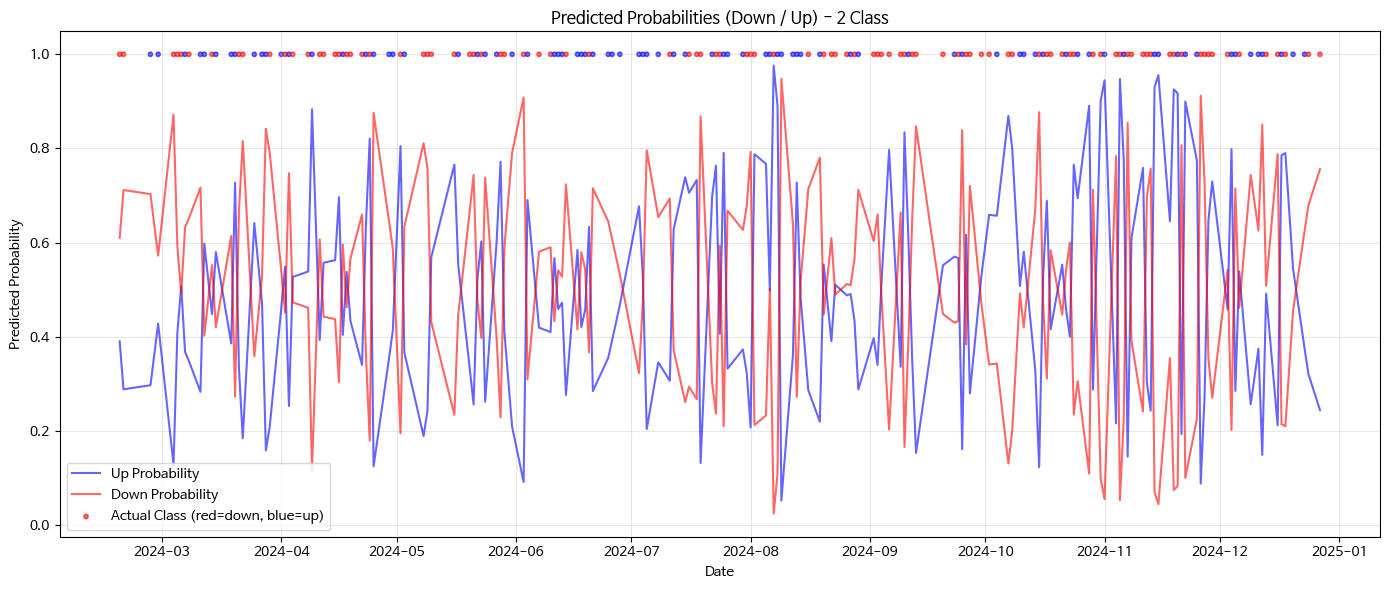

In [ ]:
# 2-class classification (up, down) with feature engineering

from pykrx import stock
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
start_date = "20220101"
end_date = "20241231"
ticker_code = "005930"  # 삼성전자
window_size = 5

OHLCV = stock.get_market_ohlcv_by_date(start_date, end_date, ticker_code)
data = OHLCV[['시가', '고가', '저가', '종가', '거래량']].copy()
data.columns = ['open', 'high', 'low', 'close', 'volume']

# 2. Feature Engineering
data['body'] = abs((data['close'] - data['open']) / data['open']) * 100
data['upper_shadow'] = (data['high'] - data[['open', 'close']].max(axis=1)) / data['open'] * 100
data['lower_shadow'] = (data[['open', 'close']].min(axis=1) - data['low']) / data['open'] * 100

# 0으로 나누는 위험 방지용 epsilon
eps = 1e-9
range_hl = (data['high'] - data['low']).replace(0, np.nan)

data['body_ratio'] = abs(data['close'] - data['open']) / (range_hl + eps)
data['shadow_ratio'] = (data['upper_shadow'] - data['lower_shadow']) / (((range_hl / data['open']) * 100) + eps)

data['direction'] = np.sign(data['close'] - data['open'])
data['volume_strength'] = data['volume'] / data['volume'].rolling(5).mean()
data['momentum'] = (data['close'] - data['close'].shift(1)) / data['close'].shift(1) * 100

# 3. 라벨링 (2-class)
data['next_close'] = data['close'].shift(-1)
data['return'] = (data['next_close'] - data['close']) / data['close'] * 100

threshold = 0.3  # ±0.3% 이내는 제외

# Down=0, Up=1, 그 외(중립)는 NaN 처리 후 제거
data['label'] = np.where(
    data['return'] < -threshold, 0,
    np.where(data['return'] > threshold, 1, np.nan)
)

# 4. 시계열 feature 추가
features = [
    'body', 'upper_shadow', 'lower_shadow', 'body_ratio',
    'shadow_ratio', 'direction', 'volume_strength', 'momentum'
]

for col in features:
    for i in range(1, window_size + 1):
        data[f'{col}_{i}_days_ago'] = data[col].shift(i)

# 라벨/피처 결측 제거
data.dropna(inplace=True)

# 5. Train/Test Split
x = data.filter(regex='_days_ago$')
y = data['label'].astype(int)

train_size = int(len(x) * 0.7)
x_train, x_test = x.iloc[:train_size], x.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 6. Binary Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)
y_prob = model.predict_proba(x_test_scaled)  # [:, 1] 이 Up 확률

# 7. 평가
print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

# 8. 시각화 (Up/Down 확률)
plt.figure(figsize=(14, 6))

up_prob = y_prob[:, 1]
down_prob = y_prob[:, 0]

plt.plot(y_test.index, up_prob, color='blue', alpha=0.6, label='Up Probability')
plt.plot(y_test.index, down_prob, color='red', alpha=0.6, label='Down Probability')

# 실제 라벨 표시 (위쪽에 점으로)
colors = y_test.map({0: 'red', 1: 'blue'})
plt.scatter(y_test.index, [1]*len(y_test), c=colors, s=10, alpha=0.6,
            label='Actual Class (red=down, blue=up)')

plt.title('Predicted Probabilities (Down / Up) - 2 Class')
plt.xlabel('Date')
plt.ylabel('Predicted Probability')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


정확도: 0.4450
[[51  9 40]
 [14  5 14]
 [39  5 41]]
              precision    recall  f1-score   support

           0     0.4904    0.5100    0.5000       100
           1     0.2632    0.1515    0.1923        33
           2     0.4316    0.4824    0.4556        85

    accuracy                         0.4450       218
   macro avg     0.3950    0.3813    0.3826       218
weighted avg     0.4331    0.4450    0.4361       218



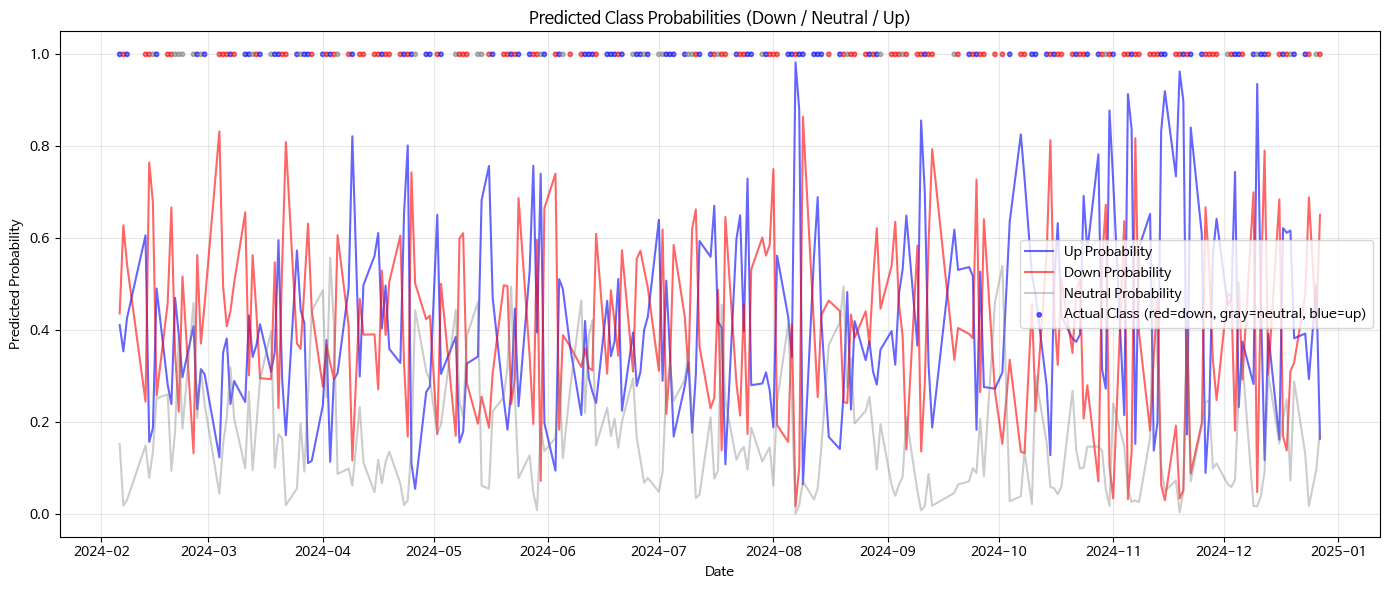

In [ ]:
# 3-class classification (up, down, neutral) with feature engineering

from pykrx import stock
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
start_date = "20220101"
end_date = "20241231"
ticker_code = "005930"  # 삼성전자
window_size = 5

OHLCV = stock.get_market_ohlcv_by_date(start_date, end_date, ticker_code)
data = OHLCV[['시가', '고가', '저가', '종가', '거래량']]
data.columns = ['open', 'high', 'low', 'close', 'volume']

# 2. Feature Engineering
data['body'] = abs((data['close'] - data['open']) / data['open']) * 100
data['upper_shadow'] = (data['high'] - data[['open', 'close']].max(axis=1)) / data['open'] * 100
data['lower_shadow'] = (data[['open', 'close']].min(axis=1) - data['low']) / data['open'] * 100
data['body_ratio'] = abs(data['close'] - data['open']) / (data['high'] - data['low'])
data['shadow_ratio'] = (data['upper_shadow'] - data['lower_shadow']) / ((data['high'] - data['low']) / data['open'] * 100)
data['direction'] = np.sign(data['close'] - data['open'])
data['volume_strength'] = data['volume'] / data['volume'].rolling(5).mean()
data['momentum'] = (data['close'] - data['close'].shift(1)) / data['close'].shift(1) * 100

# 3. 라벨링 (3-class)
data['next_close'] = data['close'].shift(-1)
data['return'] = (data['next_close'] - data['close']) / data['close'] * 100

threshold = 0.3  # ±0.3% 이내는 변동 미미로 간주
conditions = [
    data['return'] < -threshold,                 # 하락
    (data['return'] >= -threshold) & (data['return'] <= threshold),  # 변동 미미
    data['return'] > threshold                   # 상승
]
choices = [0, 1, 2]
data['label'] = np.select(conditions, choices)

# 4. 시계열 feature 추가
features = ['body', 'upper_shadow', 'lower_shadow', 'body_ratio',
            'shadow_ratio', 'direction', 'volume_strength', 'momentum']

for col in features:
    for i in range(1, window_size + 1):
        data[f'{col}_{i}_days_ago'] = data[col].shift(i)

data.dropna(inplace=True)

# 5. Train/Test Split
x = data.filter(regex='_days_ago$')
y = data['label']

train_size = int(len(x) * 0.7)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 6. Multinomial Logistic Regression
model = LogisticRegression(max_iter=1000, multi_class='multinomial')
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)
y_prob = model.predict_proba(x_test_scaled)

# 7. 평가
print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

# 8. 시각화
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_prob[:, 2], color='blue', alpha=0.6, label='Up Probability')
plt.plot(y_test.index, y_prob[:, 0], color='red', alpha=0.6, label='Down Probability')
plt.plot(y_test.index, y_prob[:, 1], color='gray', alpha=0.4, label='Neutral Probability')

# 실제 구간 색상 표시
colors = y_test.map({0: 'red', 1: 'gray', 2: 'blue'})
plt.scatter(y_test.index, [1]*len(y_test), c=colors, s=10, alpha=0.6, label='Actual Class (red=down, gray=neutral, blue=up)')

plt.title('Predicted Class Probabilities (Down / Neutral / Up)')
plt.xlabel('Date')
plt.ylabel('Predicted Probability')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# additional feature (SMA, RSI, MACD)
from pykrx import stock
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Indicator 계산 함수들
def add_sma_features(df, windows=(5, 20, 60)):
    df = df.copy()
    for w in windows:
        df[f'sma_{w}'] = df['close'].rolling(w).mean()
        # 가격 대비 SMA 괴리율(%)
        df[f'sma_{w}_dist'] = (df['close'] - df[f'sma_{w}']) / df[f'sma_{w}'] * 100
    return df


def add_macd_features(df, fast=12, slow=26, signal=9):
    df = df.copy()
    ema_fast = df['close'].ewm(span=fast, adjust=False).mean()
    ema_slow = df['close'].ewm(span=slow, adjust=False).mean()
    df['macd'] = ema_fast - ema_slow
    df['macd_signal'] = df['macd'].ewm(span=signal, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    return df


def add_rsi_features(df, period=14):
    df = df.copy()
    delta = df['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Wilder 방식에 가까운 EWM 기반
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / (avg_loss + 1e-9)
    df['rsi'] = 100 - (100 / (1 + rs))
    return df


# 베이스 Feature Engineering
def add_base_features(df):
    df = df.copy()

    df['body'] = abs((df['close'] - df['open']) / df['open']) * 100
    df['upper_shadow'] = (df['high'] - df[['open', 'close']].max(axis=1)) / df['open'] * 100
    df['lower_shadow'] = (df[['open', 'close']].min(axis=1) - df['low']) / df['open'] * 100

    eps = 1e-9
    range_hl = (df['high'] - df['low']).replace(0, np.nan)

    df['body_ratio'] = abs(df['close'] - df['open']) / (range_hl + eps)
    df['shadow_ratio'] = (df['upper_shadow'] - df['lower_shadow']) / (((range_hl / df['open']) * 100) + eps)

    df['direction'] = np.sign(df['close'] - df['open'])
    df['volume_strength'] = df['volume'] / df['volume'].rolling(5).mean()
    df['momentum'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1) * 100

    return df


# 라벨 생성
def add_labels(df, threshold=0.3, label_mode="triple"):
    """
    label_mode:
      - "triple": Down=0, Neutral=1, Up=2
      - "binary": Neutral 제거, Down=0, Up=1
    """
    df = df.copy()
    df['next_close'] = df['close'].shift(-1)
    df['return'] = (df['next_close'] - df['close']) / df['close'] * 100

    if label_mode == "triple":
        conditions = [
            df['return'] < -threshold,
            (df['return'] >= -threshold) & (df['return'] <= threshold),
            df['return'] > threshold
        ]
        choices = [0, 1, 2]
        df['label'] = np.select(conditions, choices)

    elif label_mode == "binary":
        # 중립은 NaN으로 두고 제거
        df['label'] = np.where(
            df['return'] < -threshold, 0,
            np.where(df['return'] > threshold, 1, np.nan)
        )
    else:
        raise ValueError("label_mode must be 'triple' or 'binary'")

    return df


# 시계열 lag feature 생성
def add_lag_features(df, feature_cols, window_size=5):
    df = df.copy()
    for col in feature_cols:
        for i in range(1, window_size + 1):
            df[f'{col}_{i}_days_ago'] = df[col].shift(i)
    return df


# 전체 파이프라인
def prepare_dataset(
    start_date="20220101",
    end_date="20241231",
    ticker_code="005930",
    window_size=5,
    threshold=0.3,
    label_mode="triple",
    indicator=None
):
    # OHLCV 로드
    OHLCV = stock.get_market_ohlcv_by_date(start_date, end_date, ticker_code)
    df = OHLCV[['시가', '고가', '저가', '종가', '거래량']].copy()
    df.columns = ['open', 'high', 'low', 'close', 'volume']

    indicator = indicator or []
    # 베이스 피처
    df = add_base_features(df)

    # 지표 추가
    if indicator is None:
        pass
    else:
        if "sma" in indicator:
            df = add_sma_features(df, windows=(5, 20, 60))
        if "macd" in indicator:
            df = add_macd_features(df, fast=12, slow=26, signal=9)
        if "rsi" in indicator:
            df = add_rsi_features(df, period=14)

    # 라벨
    df = add_labels(df, threshold=threshold, label_mode=label_mode)

    # 어떤 컬럼을 lag 대상으로 쓸지 결정
    base_feature_cols = [
        'body', 'upper_shadow', 'lower_shadow', 'body_ratio',
        'shadow_ratio', 'direction', 'volume_strength', 'momentum'
    ]

    indicator_cols = []
    if "sma" in indicator:
        indicator_cols += ['sma_5', 'sma_20', 'sma_60', 'sma_5_dist', 'sma_20_dist', 'sma_60_dist']
    if "macd" in indicator:
        indicator_cols += ['macd', 'macd_signal', 'macd_hist']
    if "rsi" in indicator:
        indicator_cols += ['rsi']

    feature_cols = base_feature_cols + indicator_cols

    # lag 생성
    df = add_lag_features(df, feature_cols, window_size=window_size)

    # 결측 제거
    df.dropna(inplace=True)

    # X/Y 구성
    X = df.filter(regex='_days_ago$')
    y = df['label']

    if label_mode == "binary":
        y = y.astype(int)

    return df, X, y


# 학습/평가/시각화
def run_experiment(
    label_mode="triple",
    indicator=None,
    start_date="20220101",
    end_date="20241231",
    ticker_code="005930",
    window_size=5,
    threshold=0.3,
    train_ratio=0.7,
    show_plot=True
):
    df, X, y = prepare_dataset(
        start_date=start_date,
        end_date=end_date,
        ticker_code=ticker_code,
        window_size=window_size,
        threshold=threshold,
        label_mode=label_mode,
        indicator=indicator
    )

    # 시계열 분할
    train_size = int(len(X) * train_ratio)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 모델
    # - triple: multinomial
    # - binary: default binary logistic
    if label_mode == "triple":
        model = LogisticRegression(max_iter=2000, multi_class='multinomial')
    else:
        model = LogisticRegression(max_iter=2000)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)

    # 평가 출력
    print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))

    # 시각화
    if show_plot:
        plt.figure(figsize=(14, 6))

        if label_mode == "binary":
            plt.plot(y_test.index, y_prob[:, 1], alpha=0.7, label='Up Probability')
            plt.plot(y_test.index, y_prob[:, 0], alpha=0.7, label='Down Probability')
        else:
            plt.plot(y_test.index, y_prob[:, 2], alpha=0.7, label='Up Probability')
            plt.plot(y_test.index, y_prob[:, 1], alpha=0.7, label='Neutral Probability')
            plt.plot(y_test.index, y_prob[:, 0], alpha=0.7, label='Down Probability')

        plt.xlabel('Date')
        plt.ylabel('Predicted Probability')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


    return {
        "model": model,
        "scaler": scaler,
    }



정확도: 0.4940
[[55 35]
 [49 27]]
              precision    recall  f1-score   support

           0     0.5288    0.6111    0.5670        90
           1     0.4355    0.3553    0.3913        76

    accuracy                         0.4940       166
   macro avg     0.4822    0.4832    0.4792       166
weighted avg     0.4861    0.4940    0.4866       166



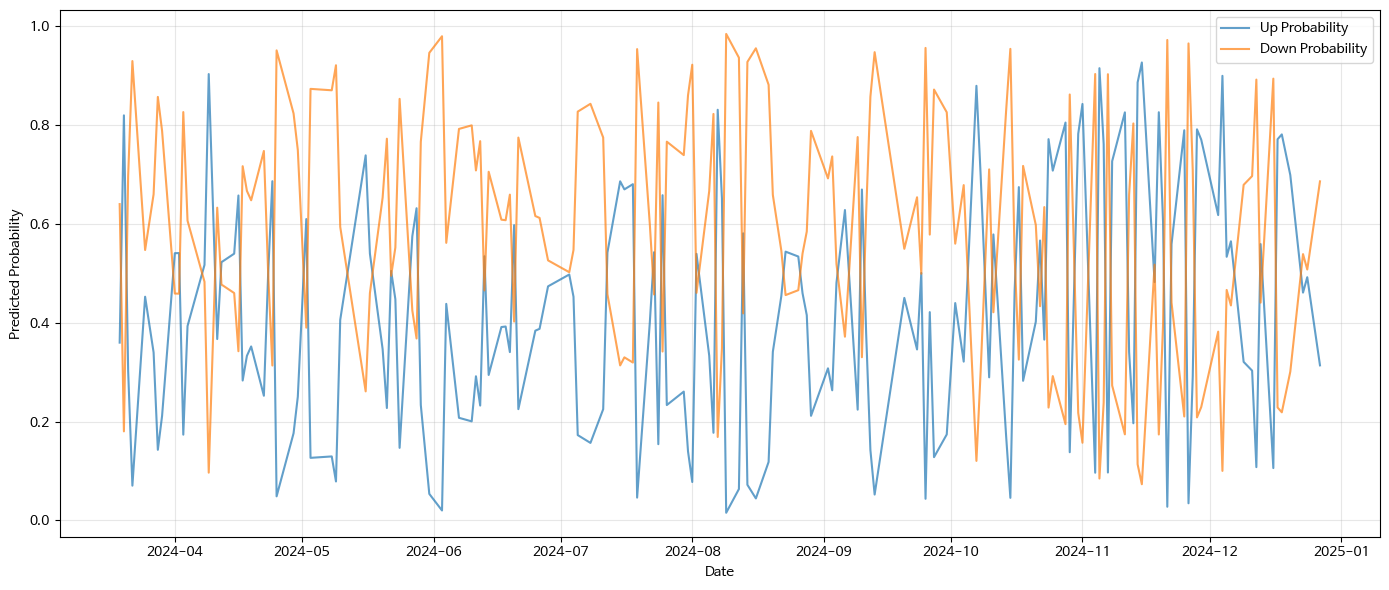

{'model': LogisticRegression(max_iter=2000), 'scaler': StandardScaler()}

In [ ]:
# 2-class + SMA
run_experiment(label_mode="binary", indicator=["sma"])

정확도: 0.5419
[[57 40]
 [42 40]]
              precision    recall  f1-score   support

           0     0.5758    0.5876    0.5816        97
           1     0.5000    0.4878    0.4938        82

    accuracy                         0.5419       179
   macro avg     0.5379    0.5377    0.5377       179
weighted avg     0.5411    0.5419    0.5414       179



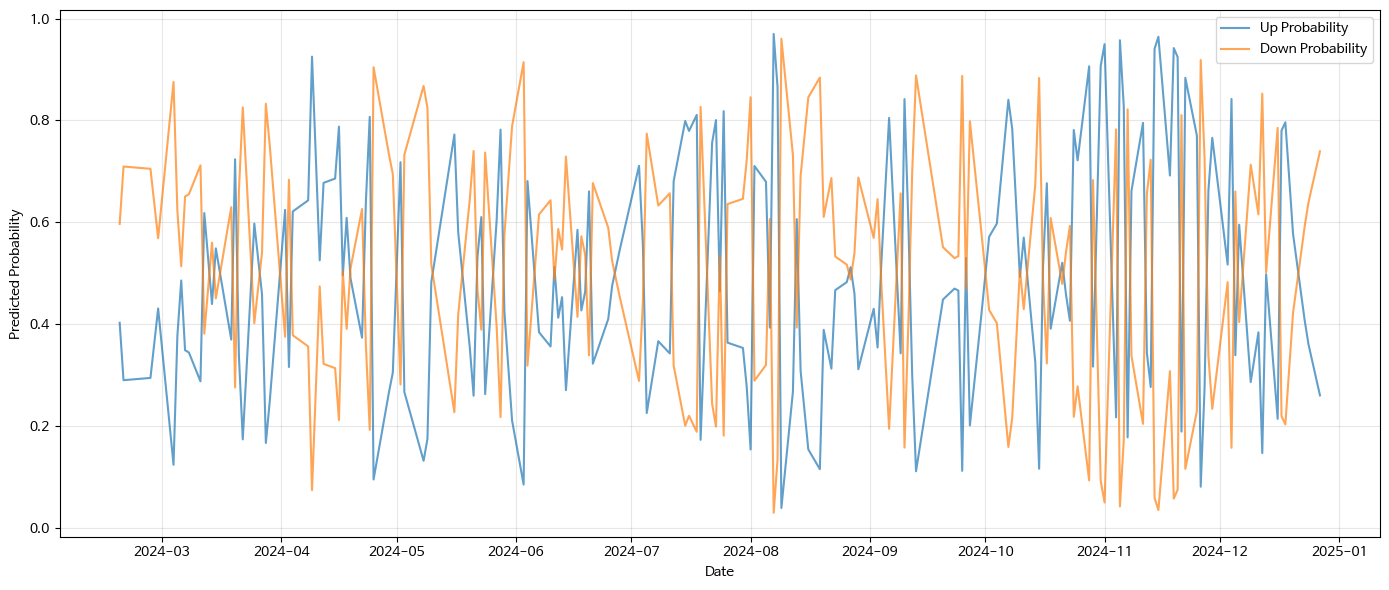

{'model': LogisticRegression(max_iter=2000), 'scaler': StandardScaler()}

In [ ]:
# 2-class + MACD
run_experiment(label_mode="binary", indicator=["macd"])

정확도: 0.5196
[[53 44]
 [42 40]]
              precision    recall  f1-score   support

           0     0.5579    0.5464    0.5521        97
           1     0.4762    0.4878    0.4819        82

    accuracy                         0.5196       179
   macro avg     0.5170    0.5171    0.5170       179
weighted avg     0.5205    0.5196    0.5199       179



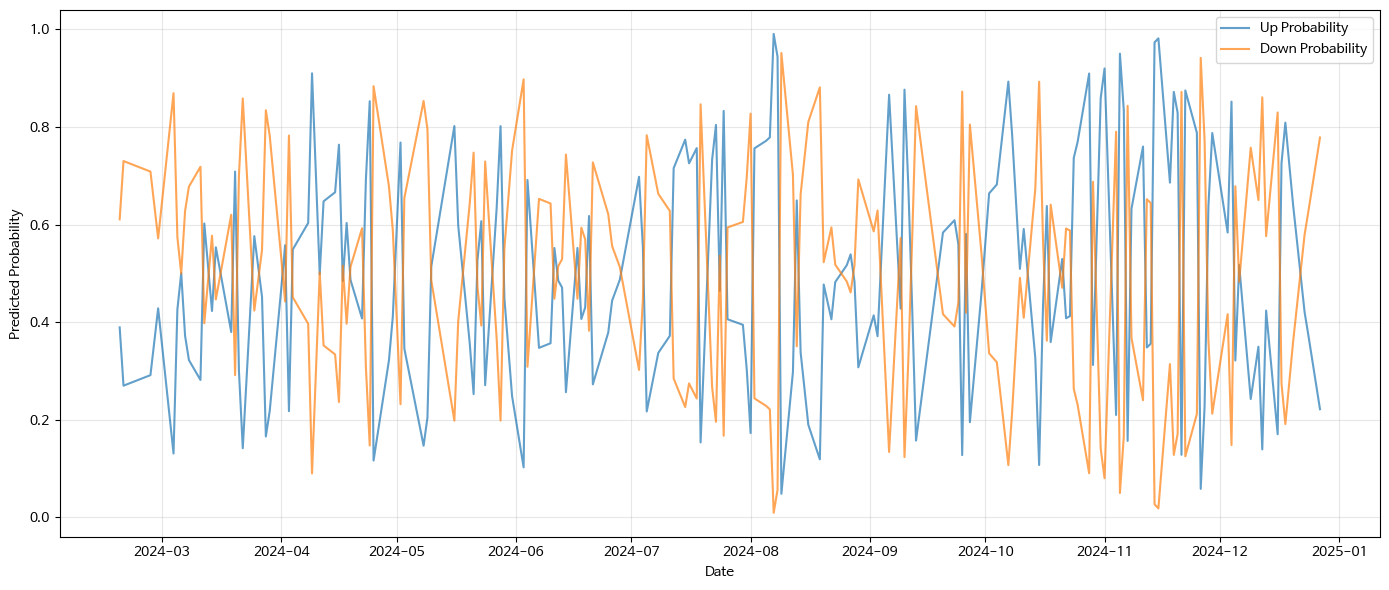

{'model': LogisticRegression(max_iter=2000), 'scaler': StandardScaler()}

In [ ]:
# 2-class + RSI
run_experiment(label_mode="binary", indicator=["rsi"])

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


정확도: 0.3267
[[38 32 25]
 [13  7  7]
 [31 28 21]]
              precision    recall  f1-score   support

           0     0.4634    0.4000    0.4294        95
           1     0.1045    0.2593    0.1489        27
           2     0.3962    0.2625    0.3158        80

    accuracy                         0.3267       202
   macro avg     0.3214    0.3073    0.2980       202
weighted avg     0.3888    0.3267    0.3469       202



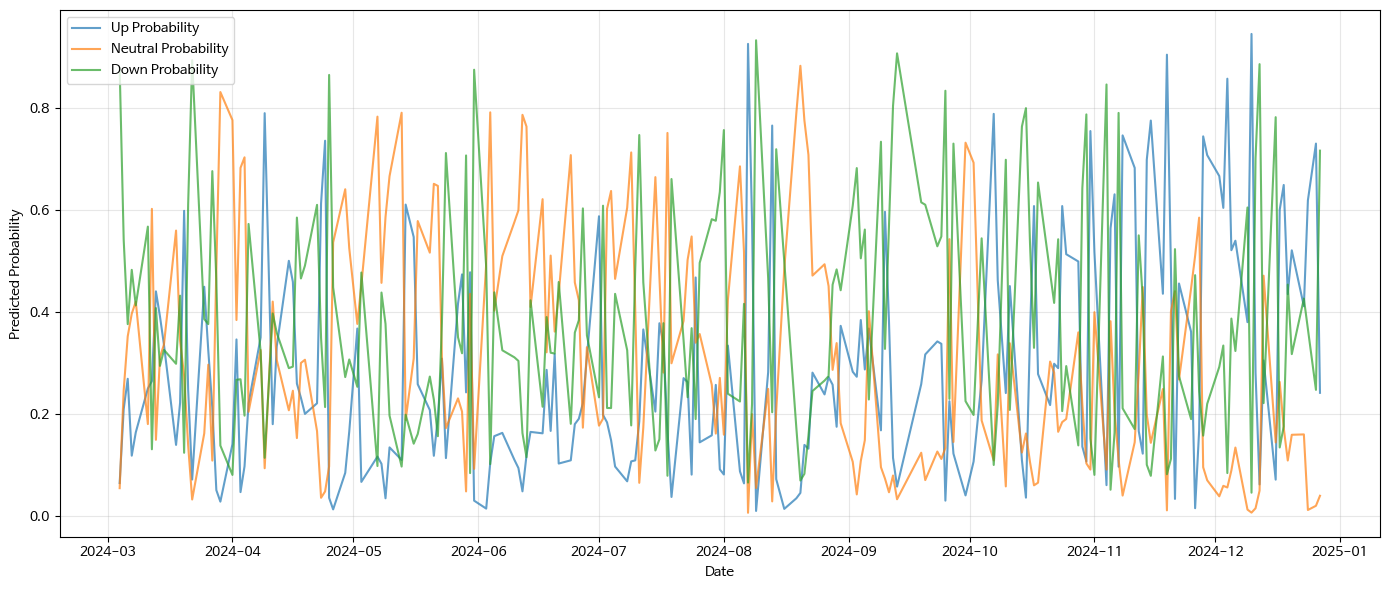

{'model': LogisticRegression(max_iter=2000, multi_class='multinomial'),
 'scaler': StandardScaler()}

In [ ]:
# 3-class + SMA
run_experiment(label_mode="triple", indicator=["sma"])

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


정확도: 0.4404
[[50 10 40]
 [12  6 15]
 [38  7 40]]
              precision    recall  f1-score   support

           0     0.5000    0.5000    0.5000       100
           1     0.2609    0.1818    0.2143        33
           2     0.4211    0.4706    0.4444        85

    accuracy                         0.4404       218
   macro avg     0.3940    0.3841    0.3862       218
weighted avg     0.4330    0.4404    0.4351       218



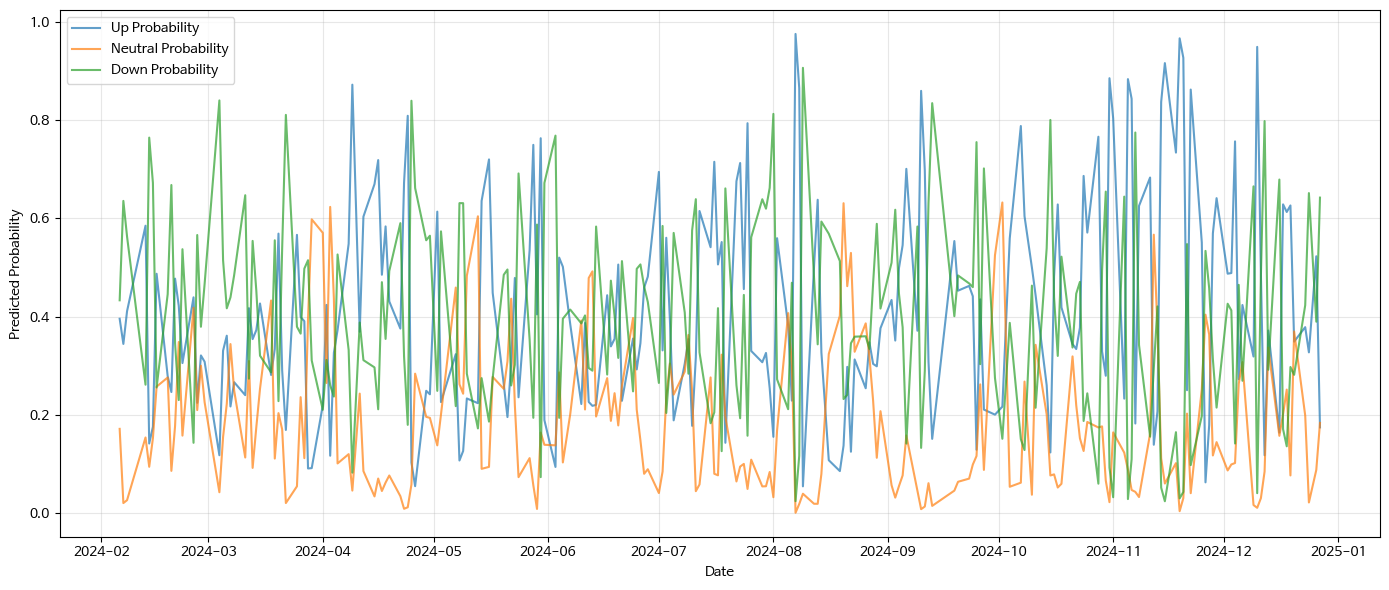

{'model': LogisticRegression(max_iter=2000, multi_class='multinomial'),
 'scaler': StandardScaler()}

In [ ]:
# 3-class + MACD
run_experiment(label_mode="triple", indicator=["macd"])

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


정확도: 0.4358
[[48 11 41]
 [13  6 14]
 [38  6 41]]
              precision    recall  f1-score   support

           0     0.4848    0.4800    0.4824       100
           1     0.2609    0.1818    0.2143        33
           2     0.4271    0.4824    0.4530        85

    accuracy                         0.4358       218
   macro avg     0.3909    0.3814    0.3832       218
weighted avg     0.4284    0.4358    0.4304       218



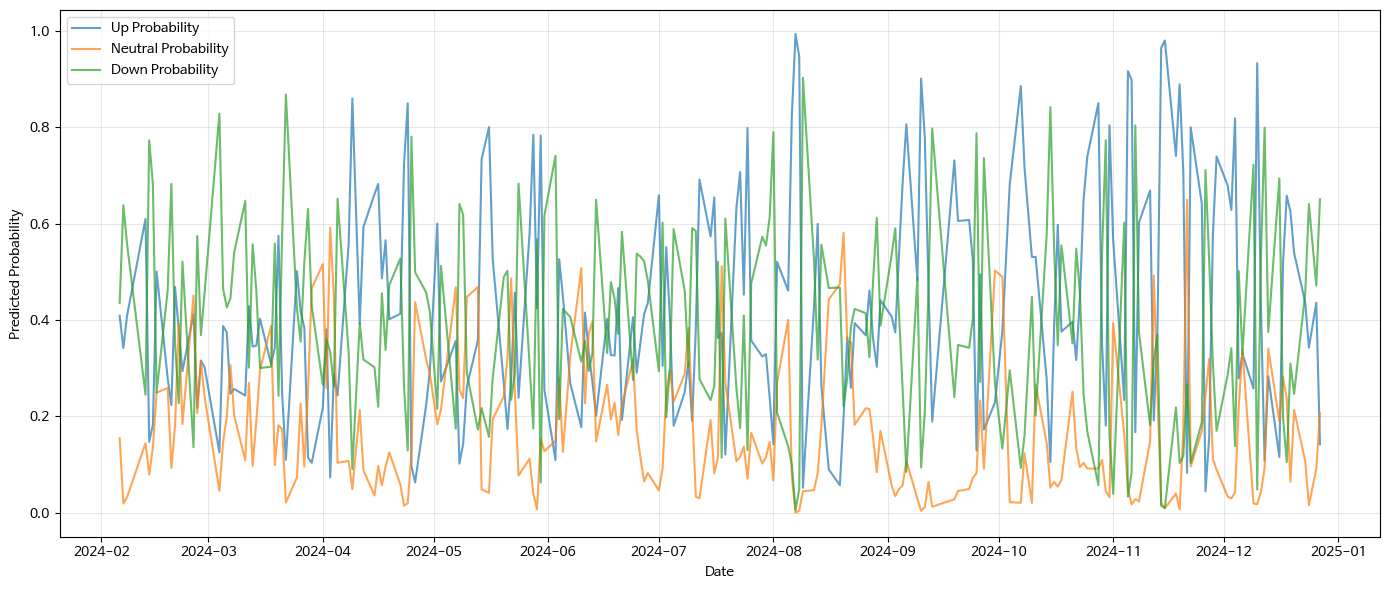

{'model': LogisticRegression(max_iter=2000, multi_class='multinomial'),
 'scaler': StandardScaler()}

In [ ]:
# 3-class + RSI
run_experiment(label_mode="triple", indicator=["rsi"])

정확도: 0.5181
[[57 33]
 [47 29]]
              precision    recall  f1-score   support

           0     0.5481    0.6333    0.5876        90
           1     0.4677    0.3816    0.4203        76

    accuracy                         0.5181       166
   macro avg     0.5079    0.5075    0.5040       166
weighted avg     0.5113    0.5181    0.5110       166



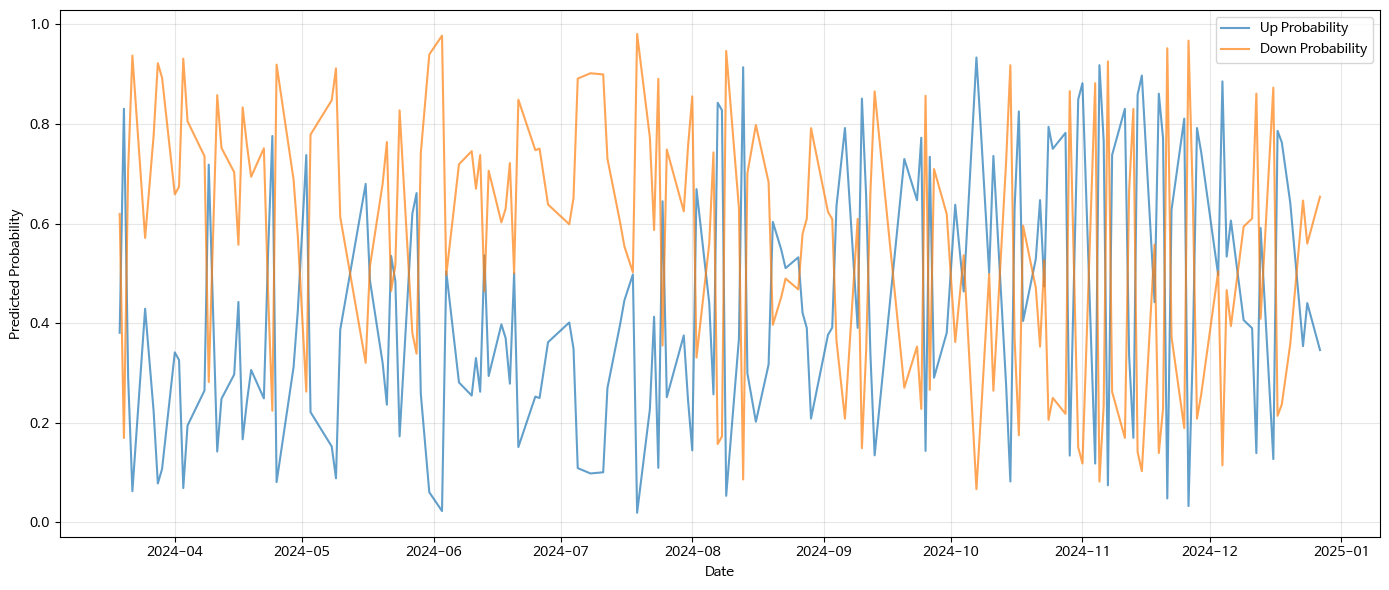

{'model': LogisticRegression(max_iter=2000), 'scaler': StandardScaler()}

In [ ]:
# 2-class + SMA + MACD + RSI
run_experiment(label_mode="binary", indicator=["sma","macd","rsi"])

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


정확도: 0.3515
[[37 29 29]
 [ 6 11 10]
 [27 30 23]]
              precision    recall  f1-score   support

           0     0.5286    0.3895    0.4485        95
           1     0.1571    0.4074    0.2268        27
           2     0.3710    0.2875    0.3239        80

    accuracy                         0.3515       202
   macro avg     0.3522    0.3615    0.3331       202
weighted avg     0.4165    0.3515    0.3695       202



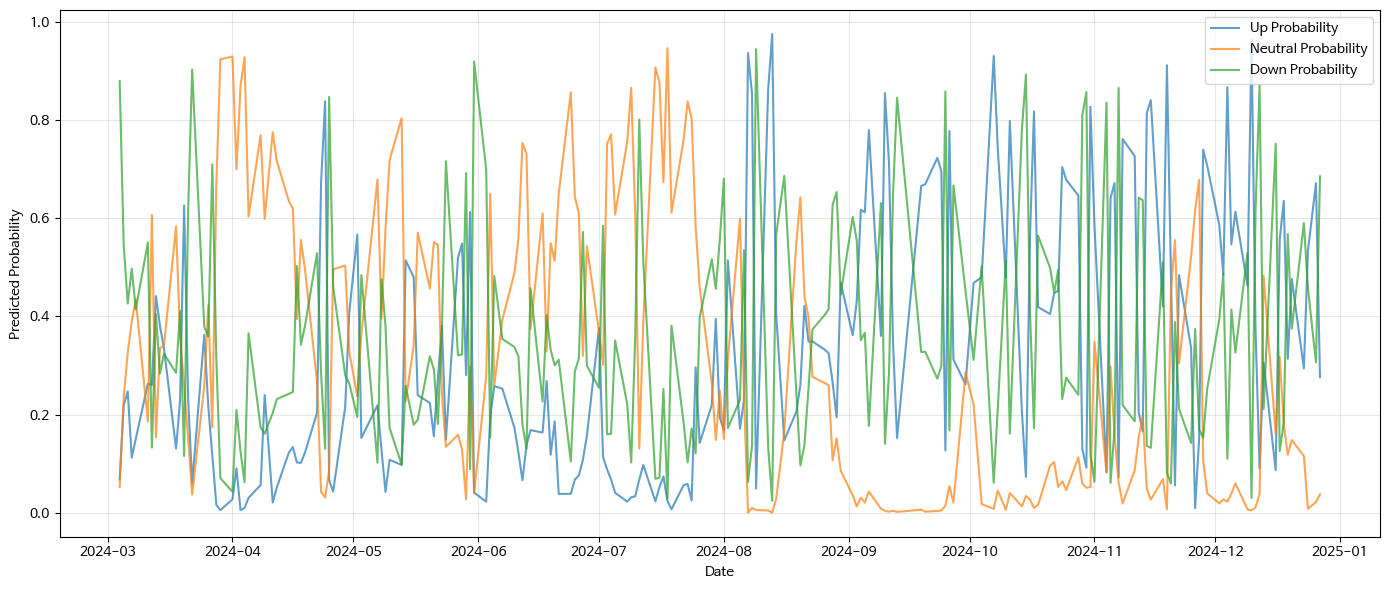

{'model': LogisticRegression(max_iter=2000, multi_class='multinomial'),
 'scaler': StandardScaler()}

In [ ]:
# 3-class + SMA + MACD + RSI
run_experiment(label_mode="triple", indicator=["sma","macd","rsi"])

정확도: 0.5363
[[56 41]
 [42 40]]
              precision    recall  f1-score   support

           0     0.5714    0.5773    0.5744        97
           1     0.4938    0.4878    0.4908        82

    accuracy                         0.5363       179
   macro avg     0.5326    0.5326    0.5326       179
weighted avg     0.5359    0.5363    0.5361       179



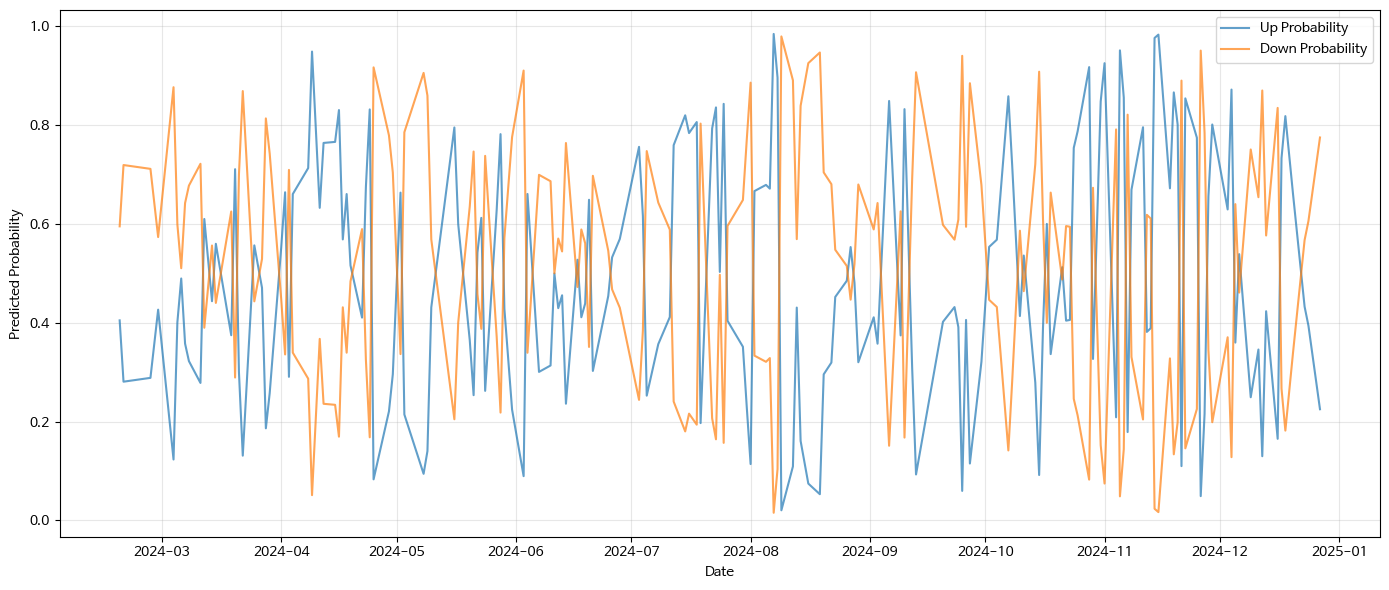

{'model': LogisticRegression(max_iter=2000), 'scaler': StandardScaler()}

In [ ]:
# 2-class + MACD + RSI
run_experiment(label_mode="binary", indicator=["macd","rsi"])

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


정확도: 0.4266
[[50 10 40]
 [12  6 15]
 [42  6 37]]
              precision    recall  f1-score   support

           0     0.4808    0.5000    0.4902       100
           1     0.2727    0.1818    0.2182        33
           2     0.4022    0.4353    0.4181        85

    accuracy                         0.4266       218
   macro avg     0.3852    0.3724    0.3755       218
weighted avg     0.4186    0.4266    0.4209       218



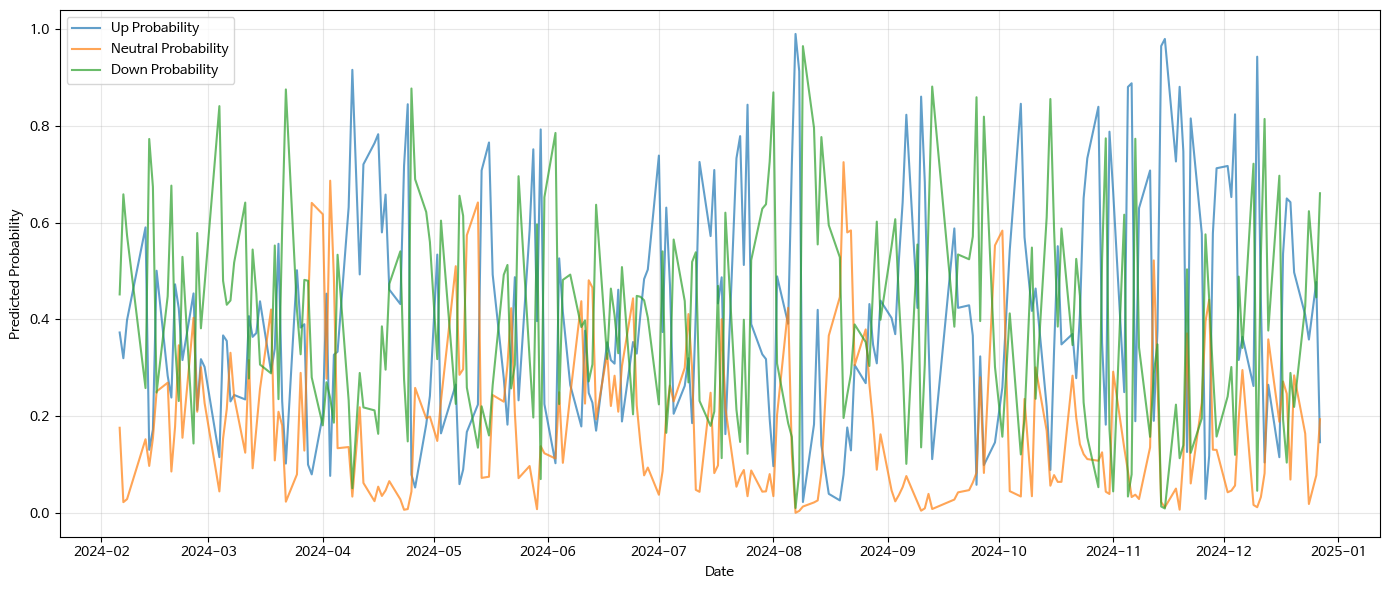

{'model': LogisticRegression(max_iter=2000, multi_class='multinomial'),
 'scaler': StandardScaler()}

In [ ]:
# 3-class + MACD + RSI
run_experiment(label_mode="triple", indicator=["macd","rsi"])